# Food Delivery Business: Demand Forecasting

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn

  Using cached pandas-3.0.0-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached numpy-2.4.1-cp313-cp313-win_amd64.whl.metadata (6.6 kB)
  Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl.metadata (52 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.8.0-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.1.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
  Using cached scipy-1.17.0-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using 


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
import pandas as pd
import numpy as np

# 1️⃣ Set seed for reproducibility
np.random.seed(500)

# 2️⃣ Increase dataset size for better model training
records = 2000  # previously 500

# 3️⃣ Generate synthetic dataset with meaningful patterns
data = {
    "order_id": range(1, records + 1),
    "restaurant_id": np.random.randint(1, 20, records),
    "food_item": np.random.choice(
        ["Pizza", "Burger", "Biryani", "Pasta", "Sandwich", "Fried Rice"], records
    ),
    "order_hour": np.random.randint(0, 24, records),
    "delivery_time_min": np.random.randint(20, 60, records),
    "order_quantity": np.random.randint(1, 6, records),
    "is_weekend": np.random.choice([0, 1], records),
    "is_holiday": np.random.choice([0, 1], records),
    "weather": np.random.choice(["Clear", "Rainy", "Cloudy"], records)
}

df = pd.DataFrame(data)

# 4️⃣ Feature Engineering for better prediction

# Peak hour indicator (business insight)
df['is_peak_hour'] = df['order_hour'].apply(lambda x: 1 if 18 <= x <= 22 else 0)

# Combined weekend & holiday effect
df['holiday_weekend'] = df['is_holiday'] * df['is_weekend']

# Average order quantity per restaurant per hour (simulated trend)
avg_orders = df.groupby(['restaurant_id', 'order_hour'])['order_quantity'].transform('mean')
df['avg_order_restaurant_hour'] = avg_orders

# 5️⃣ Save CSV
df.to_csv("food_delivery_data.csv", index=False)

df.head()


,order_id,restaurant_id,food_item,order_hour,delivery_time_min,order_quantity,is_weekend,is_holiday,weather,is_peak_hour,holiday_weekend,avg_order_restaurant_hour
0,1,2,Sandwich,9,31,4,0,0,Rainy,0,0,2.75
1,2,18,Biryani,3,22,4,0,1,Cloudy,0,0,4.00
2,3,15,Pasta,20,28,2,0,1,Clear,1,0,3.00
3,4,9,Sandwich,5,44,5,1,0,Cloudy,0,0,2.70
4,5,8,Burger,3,55,2,0,0,Clear,0,0,2.00


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")


In [42]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   order_id                   2000 non-null   int64  
 1   restaurant_id              2000 non-null   int32  
 2   food_item                  2000 non-null   str    
 3   order_hour                 2000 non-null   int32  
 4   delivery_time_min          2000 non-null   int32  
 5   order_quantity             2000 non-null   int32  
 6   is_weekend                 2000 non-null   int64  
 7   is_holiday                 2000 non-null   int64  
 8   weather                    2000 non-null   str    
 9   is_peak_hour               2000 non-null   int64  
 10  holiday_weekend            2000 non-null   int64  
 11  avg_order_restaurant_hour  2000 non-null   float64
dtypes: float64(1), int32(4), int64(5), str(2)
memory usage: 156.4 KB


In [43]:
df.describe()

,order_id,restaurant_id,order_hour,delivery_time_min,order_quantity,is_weekend,is_holiday,is_peak_hour,holiday_weekend,avg_order_restaurant_hour
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000
mean,1000.500000,9.974500,11.715000,39.590500,2.971000,0.491500,0.492500,0.203000,0.24000,2.971000
std,577.494589,5.534181,6.973958,11.665799,1.427648,0.500053,0.500069,0.402333,0.42719,0.633024
min,1.000000,1.000000,0.000000,20.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000
25%,500.750000,5.000000,6.000000,29.000000,2.000000,0.000000,0.000000,0.000000,0.00000,2.600000
50%,1000.500000,10.000000,12.000000,40.000000,3.000000,0.000000,0.000000,0.000000,0.00000,3.000000
75%,1500.250000,15.000000,18.000000,50.000000,4.000000,1.000000,1.000000,0.000000,0.00000,3.333333
max,2000.000000,19.000000,23.000000,59.000000,5.000000,1.000000,1.000000,1.000000,1.00000,5.000000


In [44]:
df.count

<bound method DataFrame.count of       order_id  restaurant_id   food_item  order_hour  delivery_time_min  \
0            1              2    Sandwich           9                 31   
1            2             18     Biryani           3                 22   
2            3             15       Pasta          20                 28   
3            4              9    Sandwich           5                 44   
4            5              8      Burger           3                 55   
...        ...            ...         ...         ...                ...   
1995      1996              9  Fried Rice          21                 21   
1996      1997              2       Pizza          15                 40   
1997      1998              3    Sandwich           2                 38   
1998      1999             17      Burger          20                 41   
1999      2000             19    Sandwich          22                 54   

      order_quantity  is_weekend  is_holiday weather  

In [45]:
df.shape    

(2000, 12)

In [46]:
df.isnull().sum()

order_id                     0
restaurant_id                0
food_item                    0
order_hour                   0
delivery_time_min            0
order_quantity               0
is_weekend                   0
is_holiday                   0
weather                      0
is_peak_hour                 0
holiday_weekend              0
avg_order_restaurant_hour    0
dtype: int64

### Order Distribution by Time of Day


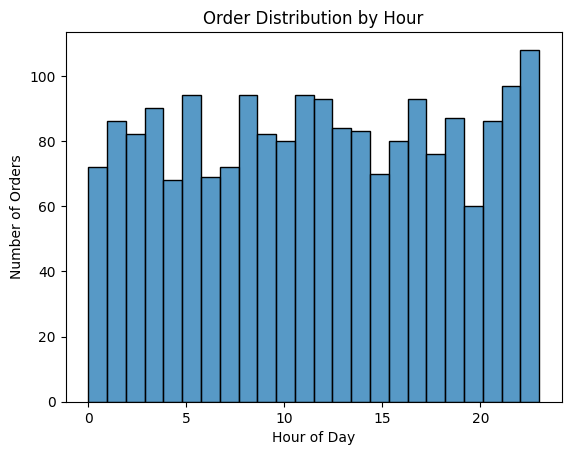

In [47]:
plt.figure()
sns.histplot(df["order_hour"], bins=24)
plt.title("Order Distribution by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.show()


### Top Selling Food Items

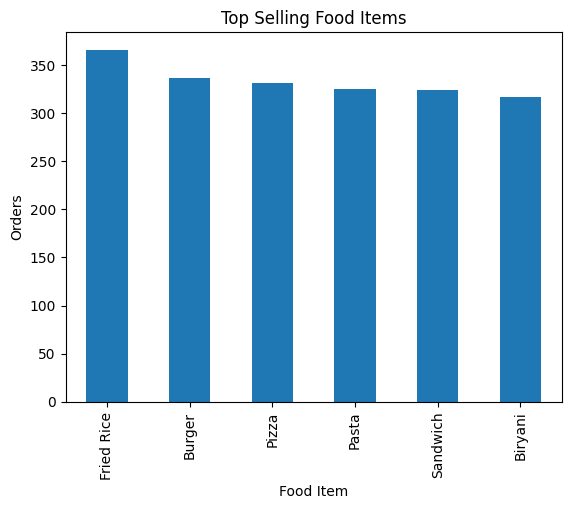

In [48]:
plt.figure()
df["food_item"].value_counts().plot(kind="bar")
plt.title("Top Selling Food Items")
plt.xlabel("Food Item")
plt.ylabel("Orders")
plt.show()


### Average Delivery Time per Restaurant

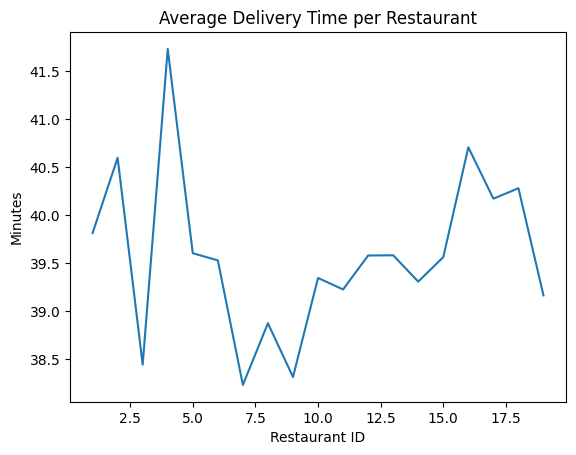

In [49]:
avg_delivery = df.groupby("restaurant_id")["delivery_time_min"].mean()

plt.figure()
avg_delivery.plot(kind="line")
plt.title("Average Delivery Time per Restaurant")
plt.xlabel("Restaurant ID")
plt.ylabel("Minutes")
plt.show()


In [50]:
df_encoded = pd.get_dummies(df, columns=["food_item", "weather"], drop_first=True)
df_encoded.head()


,order_id,restaurant_id,order_hour,delivery_time_min,order_quantity,is_weekend,is_holiday,is_peak_hour,holiday_weekend,avg_order_restaurant_hour,food_item_Burger,food_item_Fried Rice,food_item_Pasta,food_item_Pizza,food_item_Sandwich,weather_Cloudy,weather_Rainy
0,1,2,9,31,4,0,0,0,0,2.75,False,False,False,False,True,False,True
1,2,18,3,22,4,0,1,0,0,4.00,False,False,False,False,False,True,False
2,3,15,20,28,2,0,1,1,0,3.00,False,False,True,False,False,False,False
3,4,9,5,44,5,1,0,0,0,2.70,False,False,False,False,True,True,False
4,5,8,3,55,2,0,0,0,0,2.00,True,False,False,False,False,False,False


In [51]:
X = df_encoded.drop(["order_id", "order_quantity"], axis=1)
y = df_encoded["order_quantity"]


In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [53]:
model = LinearRegression()
model.fit(X_train, y_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [54]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("R2 Score:", r2)


MAE: 1.1292171459482245
MSE: 1.8492145084815876
R2 Score: 0.10242925941088887


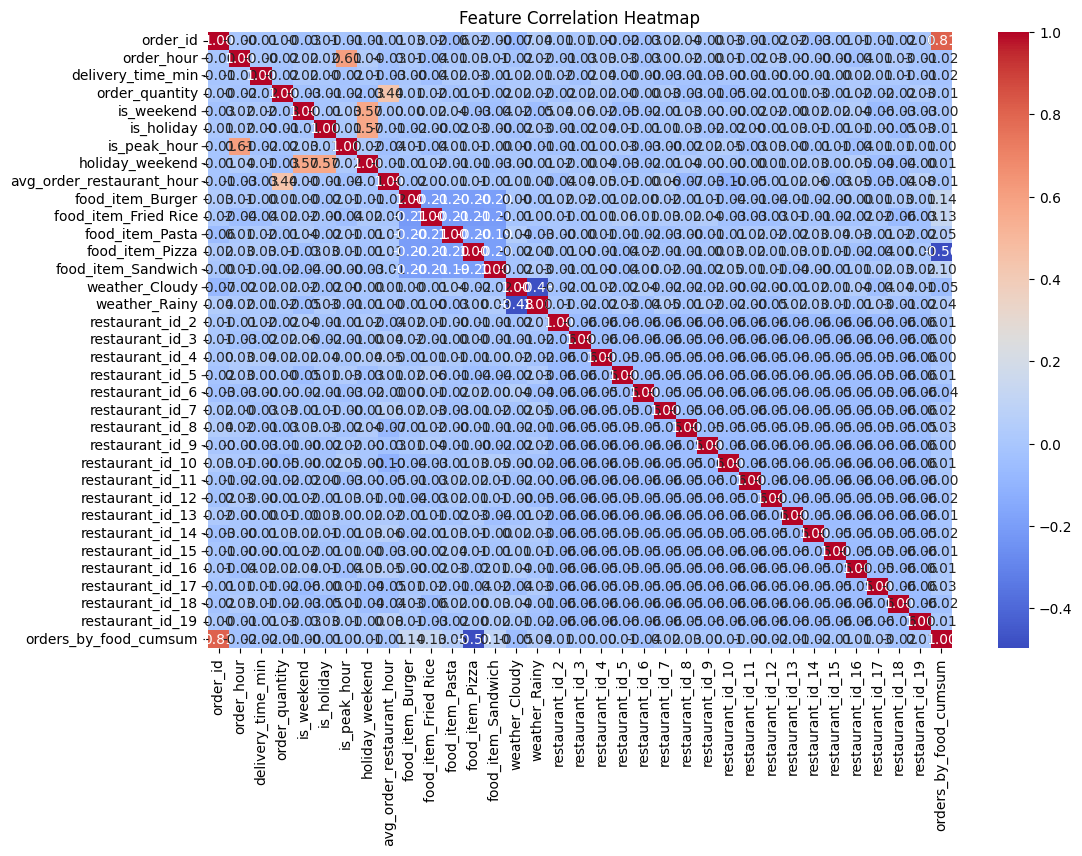

In [60]:
#heatmap to visualize feature correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [59]:
sample = X_test.iloc[0:1]
predicted_demand = model.predict(sample)

print("Predicted Order Quantity:", round(predicted_demand[0], 2))


Predicted Order Quantity: 2.26


In [56]:
# Save the trained model
import joblib
joblib.dump(model, "demand_forecasting_model.pkl")

['demand_forecasting_model.pkl']